# Load Senitnel-2 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-2 data from the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac). You may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) directly from the git repository by cloning the repository, directing into `xcube-stac`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-stac
pip install .
```

Note that [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store, get_data_store_params_schema
import itertools
import rasterio

CPU times: user 3.48 s, sys: 304 ms, total: 3.78 s
Wall time: 1.91 s


Next store the credentials in a dictionary. 

In [2]:
credentials = {
    "key": "O0M0CUQIDQO9TDZ4D8NR",
    "secret": "qPUyXs9G6j8on6MY5KPhQNHuA5uZTqxEscrbBCGx"
}

First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that key and secret of the S3 access are required.

In [3]:
%%time
store_params = get_data_store_params_schema("stac-cdse")
store_params

CPU times: user 1.04 s, sys: 160 ms, total: 1.2 s
Wall time: 1.21 s


Note that the user does not need to provide the URL for the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html). Only the key and secret for S3 access are required when initializing a `stac-cdse` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). First, we will initialize a store supporting the stacking mode. Then, for completeness, we will initialize a store in single-tile mode.

In [4]:
%%time
store = new_data_store("stac-cdse", stack_mode=True, **credentials)

CPU times: user 10.5 ms, sys: 7.76 ms, total: 18.2 ms
Wall time: 125 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [5]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 7.86 ms, sys: 456 μs, total: 8.32 ms
Wall time: 61.5 ms


['COP-DEM',
 'S2GLC',
 'TERRAAQUA',
 'SENTINEL-3',
 'SENTINEL-5P',
 'SENTINEL-1-RTC',
 'SENTINEL-1',
 'SMOS',
 'LANDSAT-7',
 'CCM',
 'LANDSAT-5',
 'LANDSAT-8',
 'ENVISAT',
 'SENTINEL-6',
 'GLOBAL-MOSAICS',
 'SENTINEL-2']

Below, the parameters for the `open_data` method can be viewed. Note that `processing_level` and and [`processing_baseline`](https://sentiwiki.copernicus.eu/web/s2-processing#S2Processing-ProcessingBaseline) can be selected. 

In [6]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 58 μs, sys: 6 μs, total: 64 μs
Wall time: 72.7 μs


So far, only data from the collection `SENTINEL-2` can be accessed. We therefore assign `data_id` to `"SENTINEL-2"`. We set the bounding box to cover the greater Hamburg area and the time range to July 2020. Additionally, we assign the processing level to `"L2A"` and the processing baseline to `"5.00"`.

We can apply a reprojection by setting `crs` to the desired output projection. The odc-stac library uses [`rasterio.wrap.reproject`](https://rasterio.readthedocs.io/en/stable/topics/reproject.html) to handle the reprojection. All arguments of [`odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) can be passed into the `open_data(...)` method, which forwards them to the `odc.stac.load` function.

In [7]:
%%time
bbox = [9.8, 53.4, 10.2, 53.7]
time_range = ["2020-07-01", "2020-07-15"]

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 8.34 μs


In [8]:
%%time
ds = store.open_data(
    data_id="SENTINEL-2",
    bbox=bbox,
    time_range=time_range,
    processing_level="L2A",
    processing_baseline="5.00",
    resolution=0.00018,
    crs="EPSG:4326",
)
ds

CPU times: user 3min 8s, sys: 29.1 s, total: 3min 37s
Wall time: 13min 4s


<xarray.Dataset> Size: 1GB
Dimensions:      (latitude: 1668, longitude: 2223, time: 6)
Coordinates:
  * latitude     (latitude) float64 13kB 53.7 53.7 53.7 53.7 ... 53.4 53.4 53.4
  * longitude    (longitude) float64 18kB 9.8 9.8 9.8 9.801 ... 10.2 10.2 10.2
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2020-07-01T10:36:29.024000 ... 202...
Data variables: (12/15)
    AOT          (time, latitude, longitude) float32 89MB 186.0 186.0 ... 126.0
    B01          (time, latitude, longitude) float32 89MB 3.935e+03 ... 4.238...
    B02          (time, latitude, longitude) float32 89MB 3.898e+03 ... 4.168...
    B03          (time, latitude, longitude) float32 89MB 3.454e+03 ... 4.22e+03
    B04          (time, latitude, longitude) float32 89MB 3.438e+03 ... 4.124...
    B05          (time, latitude, longitude) float32 89MB 3.813e+03 ... 4.507...
    ...           ...
    B8A          (time, latitude, longitude) float32 89MB 4.764e+03 ... 5.693...
    B09          (time, latitude, longitude) float32 89MB 6.621e+03 ... 8.172...
    B11          (time, latitude, longitude) float32 89MB 3.627e+03 ... 4.66e+03
    B12          (time, latitude, longitude) float32 89MB 3.236e+03 ... 4.071...
    SCL          (time, latitude, longitude) float32 89MB 8.0 8.0 ... 9.0 9.0
    WVP          (time, latitude, longitude) float32 89MB 2.057e+03 ... 1.525...

Note that the search function in the CDSE STAC API is very slow. Further investigation and comparison with other STAC APIs is needed. 

Since the tiles of the Sentinel-2 L2A in this STAC catalog are stored as `.jp2`, we can also open the data as a [xcube's multi-resolution dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets), where each level is linked to an overview level of the data pyramid. The number of levels can be extracted as shown below. 

In [9]:
%%time
mlds = store.open_data(
    data_id="SENTINEL-2",
    data_type="mldataset",
    bbox=bbox,
    time_range=time_range,
    processing_level="L2A",
    processing_baseline="5.00",
    crs="EPSG:4326",
)
mlds.num_levels

CPU times: user 7min 23s, sys: 1min 42s, total: 9min 5s
Wall time: 56min 38s


5

To get a specific level, we use the `get_dataset(idx_level)` method.

In [10]:
%%time
ds = mlds.get_dataset(4)
ds

CPU times: user 16 μs, sys: 3 μs, total: 19 μs
Wall time: 21.2 μs


<xarray.Dataset> Size: 5MB
Dimensions:      (latitude: 106, longitude: 140, time: 6)
Coordinates:
  * latitude     (latitude) float64 848B 53.4 53.4 53.41 ... 53.7 53.7 53.7
  * longitude    (longitude) float64 1kB 9.8 9.803 9.806 ... 10.2 10.2 10.2
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2020-07-01T10:36:29.024000 ... 202...
Data variables: (12/15)
    AOT          (time, latitude, longitude) float32 356kB 204.0 202.0 ... 132.0
    B01          (time, latitude, longitude) float32 356kB 1.246e+04 ... 1.22...
    B02          (time, latitude, longitude) float32 356kB 1.201e+04 ... 2.61...
    B03          (time, latitude, longitude) float32 356kB 1.144e+04 ... 2.36...
    B04          (time, latitude, longitude) float32 356kB 1.114e+04 ... 2.21...
    B05          (time, latitude, longitude) float32 356kB 1.179e+04 ... 2.33...
    ...           ...
    B8A          (time, latitude, longitude) float32 356kB 1.108e+04 ... 2.56...
    B09          (time, latitude, longitude) float32 356kB 1.657e+04 ... 2.18...
    B11          (time, latitude, longitude) float32 356kB 6.466e+03 ... 2.72...
    B12          (time, latitude, longitude) float32 356kB 4.752e+03 ... 2.09...
    SCL          (time, latitude, longitude) float32 356kB 9.0 9.0 ... 7.0 10.0
    WVP          (time, latitude, longitude) float32 356kB 2.057e+03 ... 1.52...

We can plot a tile of the B04 (red) band for a given timestamp as an example. Note that the bounding box encompasses all tiles within the dataset, so without mosaicking, many of the pixels will be NaN values.

In [11]:
%%time
session = rasterio.session.AWSSession(
    aws_unsigned=False,
    endpoint_url="eodata.dataspace.copernicus.eu",
    aws_access_key_id=credentials["key"],
    aws_secret_access_key=credentials["secret"],
)

CPU times: user 18.1 ms, sys: 2.94 ms, total: 21 ms
Wall time: 19.6 ms


CPU times: user 536 ms, sys: 49.5 ms, total: 585 ms
Wall time: 584 ms


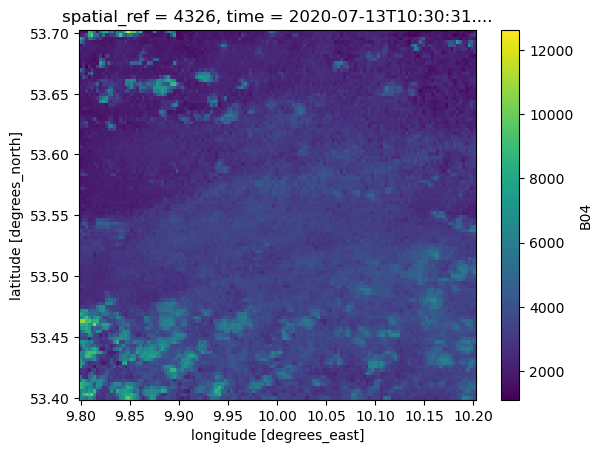

In [12]:
%%time
with rasterio.Env(session, AWS_VIRTUAL_HOSTING=False):
    ds.B04.isel(time=-1).plot()

To apply mosaicking, we need to assign `groupby="solar_day"`, as shown in the [documentation of `odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html).

In [13]:
%%time
mlds = store.open_data(
    data_id="SENTINEL-2",
    data_type="mldataset",
    bbox=bbox,
    time_range=time_range,
    processing_level="L2A",
    processing_baseline="5.00",
    crs="EPSG:4326",
    groupby="solar_day",
)

CPU times: user 5min 53s, sys: 1min 22s, total: 7min 16s
Wall time: 37min 39s


We again select the desired level and plot the same example as before. 

In [14]:
%%time
ds = mlds.get_dataset(4)
ds

CPU times: user 18 μs, sys: 4 μs, total: 22 μs
Wall time: 24.1 μs


<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 106, longitude: 140, time: 4)
Coordinates:
  * latitude     (latitude) float64 848B 53.4 53.4 53.41 ... 53.7 53.7 53.7
  * longitude    (longitude) float64 1kB 9.8 9.803 9.806 ... 10.2 10.2 10.2
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 32B 2020-07-03T10:30:31.024000 ... 202...
Data variables: (12/15)
    AOT          (time, latitude, longitude) float32 237kB 186.0 184.0 ... 132.0
    B01          (time, latitude, longitude) float32 237kB 4.491e+03 ... 1.22...
    B02          (time, latitude, longitude) float32 237kB 2.529e+03 ... 2.61...
    B03          (time, latitude, longitude) float32 237kB 2.394e+03 ... 2.36...
    B04          (time, latitude, longitude) float32 237kB 2.071e+03 ... 2.21...
    B05          (time, latitude, longitude) float32 237kB 2.307e+03 ... 2.33...
    ...           ...
    B8A          (time, latitude, longitude) float32 237kB 3.696e+03 ... 2.56...
    B09          (time, latitude, longitude) float32 237kB 5.724e+03 ... 2.18...
    B11          (time, latitude, longitude) float32 237kB 2.185e+03 ... 2.72...
    B12          (time, latitude, longitude) float32 237kB 1.695e+03 ... 2.09...
    SCL          (time, latitude, longitude) float32 237kB 9.0 9.0 ... 7.0 10.0
    WVP          (time, latitude, longitude) float32 237kB 2.021e+03 ... 1.52...

CPU times: user 68.9 ms, sys: 3.73 ms, total: 72.7 ms
Wall time: 70.5 ms


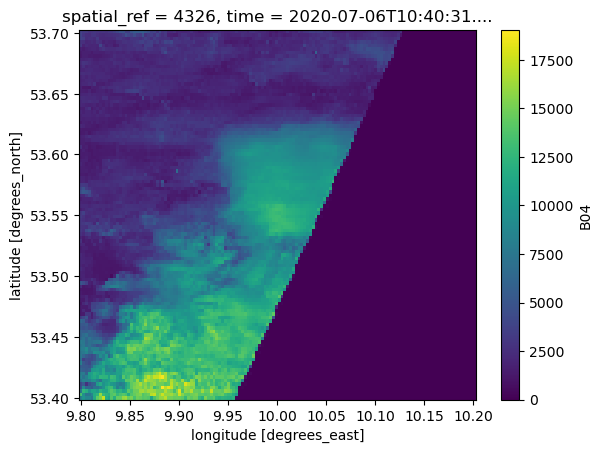

In [15]:
%%time
with rasterio.Env(session, AWS_VIRTUAL_HOSTING=False):
    ds.B04.isel(time=1).plot()

----
## Data store in the single-tile
For completeness, we initiate the data store in the single-tile mode and open data of one tile. 

In [16]:
%%time
store = new_data_store("stac-cdse", stack_mode=False, **credentials)

CPU times: user 15.4 ms, sys: 1.51 ms, total: 16.9 ms
Wall time: 152 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [17]:
%%time
data_ids = store.get_data_ids()
list(itertools.islice(data_ids, 10))

CPU times: user 14.3 ms, sys: 331 μs, total: 14.7 ms
Wall time: 532 ms


['collections/SENTINEL-3/items/S3A_REP1_AUX_POEORB_POD__20161216T083833_V20160226T215943_20160227T235943_DGNS.EOF',
 'collections/SENTINEL-3/items/S3A_REP1_AUX_POEORB_POD__20161216T181714_V20160225T215943_20160226T235943_DGNS.EOF',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_PROQUA_POD__20191108T113655_V20160224T235943_20160225T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T193419_V20160225T072708_20160225T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T194404_V20160226T235943_20160227T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T193142_V20160223T235943_20160224T225600',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T194851_V20160227T235943_20160228T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_PROQUA_POD__20191108T114132_V20160225T235943_20160226T235942',
 'collections/SENTINEL-3/items/S3A_REP1_AUX_PRCPTF_POD__20161216T085612_V20160227T215943_20160228T235943.EOF',
 'collections/S

In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [18]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 32 μs, sys: 7 μs, total: 39 μs
Wall time: 41.7 μs


 Note that since only the data access for Sentinel-2 data is supported so far, we will search for tiles of Sentinel-2 data.

In [19]:
%%time
descriptors = list(
    store.search_data(
        collections=["SENTINEL-2"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
        processing_level="L2A",
        processing_baseline="2.14",   
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 180 ms, sys: 3.83 ms, total: 183 ms
Wall time: 5.41 s


[{'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0214_R108_T32TMT_20200703T142409.SAFE',
  'data_type': 'dataset',
  'bbox': [7.662865161895752,
   46.85817337036133,
   9.130471229553223,
   47.85363006591797],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0214_R108_T32TNT_20200703T142409.SAFE',
  'data_type': 'dataset',
  'bbox': [8.99973201751709,
   46.86417007446289,
   9.683835983276367,
   47.853702545166016],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0214_R108_T32UNU_20200703T142409.SAFE',
  'data_type': 'dataset',
  'bbox': [8.999727249145508,
   47.761051177978516,
   10.0947847366333,
   48.753013610839844],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [20]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.43 ms


We select the band B04 (red), B03 (green), and B02 (blue) and lazily load the corresponding data.

In [21]:
%%time
ds = store.open_data(
    descriptors[3].data_id,
    bands=["B04", "B03", "B02"]
)
ds

CPU times: user 520 ms, sys: 85.3 ms, total: 606 ms
Wall time: 4.72 s


<xarray.Dataset> Size: 723MB
Dimensions:      (y: 10977, x: 10977)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    B04          (y, x) uint16 241MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03          (y, x) uint16 241MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02          (y, x) uint16 241MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

We plot the loaded data as an example below.

In [ ]:
%%time
ds.B04[:5000, :5000].plot()

We can also open a `.jp2` as a [xcube's multi-resolution  dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets), where we can select the level of resolution, shown below.  

In [ ]:
%%time
mlds = store.open_data(
    descriptors[3].data_id,
    bands=["B04", "B03", "B02"],
    data_type="mldataset"
)
mlds.num_levels

In [ ]:
ds = mlds.get_dataset(4)
ds

In [ ]:
%%time
ds.B04[:312, :312].plot(vmin=0.0, vmax=0.2)